# ESWEEK Tutorial 5

In [1]:
# Standard library imports
import subprocess
import time
from datetime import datetime
import pickle

# External library imports
from prometheus_api_client import PrometheusConnect
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit

In [2]:
# Prometheus server URL for live mode
g_live_mode_prometheus_url = "http://localhost:9090"

# Use pre-collected data for offline mode
g_offline_mode_data_path = "./offline-data"

# Understanding CPU Utilization Measurement

When measuring CPU utilization, we often rely on the `node_cpu_seconds_total` metric, which plays a pivotal role in understanding how CPUs are being utilized. Let's break down the key concepts step by step:

1. **`node_cpu_seconds_total` as a Counter Metric:** This metric behaves like a counter, continuously increasing as time goes by. It effectively accumulates the total amount of time that a CPU has spent in a specific state (commonly "idle"). The absolute value of node_cpu_seconds_total may not be very useful because it depends on when the exporter was started and resets to 0 upon every restart. It alone doesn't offer immediate insights into CPU utilization.

2. **Calculating the Rate of Change:** To gain meaningful insights from `node_cpu_seconds_total`, we assess how much it has changed over a defined period. Calculating the rate of change allows us to determine the fraction of time the CPU was idle during that specific timeframe. Two functions, `rate` and `irate`, are commonly employed for this purpose:

   - `rate(node_cpu_seconds_total{mode="idle"}[10s])`: This function computes the average rate of increase in the "idle" state over the past 10 seconds. It provides a smoothed, averaged value over that period.

   - `irate(node_cpu_seconds_total{mode="idle"}[10s])`: In contrast, this function calculates the instantaneous rate of increase in the "idle" state, considering the last two data samples within the past 10 seconds. It offers a more immediate, sample-based value.

3. **Interpreting the Ratio:** Both `rate` and `irate` return a ratio, ranging from 0.0 to 1.0, signifying the proportion of time the CPU was in an idle state during the specified time interval.

4. **Obtaining CPU Idle Percentage:** To express CPU idle time as a percentage, we multiply this ratio by 100. This yields the CPU idle percentage, which tells us how much of the CPU's time was spent in an idle state:

    ```(rate(node_cpu_seconds_total{mode="idle"}[10s]) * 100```


6. **Aggregating Across Instances:** In a cluster or multi-host environment, `avg by (instance)` clause creates a vector of CPU idle percentages of all the instances (hosts) in the cluster.

7. **Calculating CPU Utilization:** To derive CPU utilization, we subtract the average CPU idle percentage (as obtained using `avg by (instance)`) from 100. This creates a vector of CPU utilization percentages, reflecting the level of CPU activity across each host in the cluster.

   ```100 - (avg by (instance) (rate(node_cpu_seconds_total{mode="idle"}[10s])) * 100```

# PromQL queries for CPU Utilization and Power

In [3]:
g_cpu_query = '100 - (avg by (instance) (rate(node_cpu_seconds_total{job="node_exporter_yv3",mode="idle"}[10s])) * 100)'
g_power_query = 'hsc_input_power'

## Helper function to get data from prometheus server (only required for online mode)

In [4]:
def fetch_and_process_data(cpu_query, power_query, start_time, end_time, filter_instances=None, step=1):
        
    # Create a Prometheus client
    prometheus = PrometheusConnect(url=g_live_mode_prometheus_url)
    
    try:
        cpu_results = prometheus.custom_query_range(cpu_query, start_time, end_time, step=step)
        power_results = prometheus.custom_query_range(power_query, start_time, end_time, step=step)

        # Rewrite the instance name for power results
        for result in power_results:
            result['metric']['instance'] = f"{result['metric']['sled']}-h{result['metric']['slot']}.ics.uci.edu:9100"

        cpu_data = {}
        power_data = {}

        for result in cpu_results:
            instance_name = result['metric']['instance']
            if filter_instances is None or instance_name in filter_instances:
                timestamps = [point[0] for point in result['values']]
                values = [float(point[1]) for point in result['values']]
                cpu_data[instance_name] = {'timestamps': timestamps, 'values': values}

        for result in power_results:
            instance_name = result['metric']['instance']
            if filter_instances is None or instance_name in filter_instances:
                timestamps = [point[0] for point in result['values']]
                values = [float(point[1]) for point in result['values']]
                power_data[instance_name] = {'timestamps': timestamps, 'values': values}

        return cpu_data, power_data

    except Exception as e:
        print(f"Error querying Prometheus: {e}")
        return None, None

## Helper function for plots

In [5]:
def timeline_plot(cpu_data, power_data):
    if cpu_data is None or power_data is None:
        return

    cpu_color='steelblue'
    power_color='crimson'
    
    for instance_name, data in cpu_data.items():
        fig, ax1 = plt.subplots(figsize=(8, 5))
        
        timestamps = data['timestamps']
        # Offset the timestamps to start from 0 and convert to minutes
        timestamps = [(t - timestamps[0]) / 60 for t in timestamps]
        cpu_values = data['values']
        ax1.plot(timestamps, cpu_values, label=f'CPU Utilization', color=cpu_color)

        ax1.set_xlabel('Time (minutes)')
        ax1.set_ylabel('CPU Utilization (%)', color=cpu_color)
        ax1.tick_params(axis='y', labelcolor=cpu_color)

        ax2 = ax1.twinx()

        timestamps = power_data[instance_name]['timestamps']
        timestamps = [(t - timestamps[0]) / 60 for t in timestamps]
        power_values = power_data[instance_name]['values']
        ax2.plot(timestamps, power_values, label=f'Power', color=power_color, linestyle='dashed')

        ax2.set_ylabel('Power', color=power_color)
        ax2.tick_params(axis='y', labelcolor=power_color)
    
        plt.title(f'{instance_name} workload')
        plt.grid(True)
    
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='lower right')
    
        plt.show()
    
def scatter_plot(aligned_data):
    plt.figure(figsize=(10, 6))  # Create a single figure for all hosts
    
    # Get a colormap with the number of colors matching the number of hosts
    cmap = cm.get_cmap('tab10', len(aligned_data))
    
    for i, (host, data) in enumerate(aligned_data.items()):
        cpu_values = data['cpu']
        power_values = data['power']
        
        # Use a color from the colormap for each host
        color = cmap(i)
        
        # Create a scatter plot for the current host with the specified color
        plt.scatter(cpu_values, power_values, label=host, alpha=0.5, c=color)
    
    plt.xlabel('CPU Util')
    plt.ylabel('Power')
    plt.title('Scatter Plot for CPU Utilization and Power')
    plt.legend()
    plt.grid(True)
    plt.show()

## Helper function to switch between online/offline mode

In [6]:
def load_data(offline_mode=True, exp_config=None):
    cpu_data, power_data = None, None

    # Load data from Prometheus if running in online mode
    if not offline_mode:
        cpu_data, power_data = fetch_and_process_data(g_cpu_query, 
                                                      g_power_query, 
                                                      datetime.fromtimestamp(exp_config["start_time"]), 
                                                      datetime.fromtimestamp(exp_config["end_time"]), 
                                                      filter_instances=exp_config["filter_instance"],
                                                      step = exp_config.get("step", 1))

        with open(g_offline_mode_data_path + '/' + exp_config["offline_filename"], 'wb') as file:
            pickle.dump((cpu_data, power_data), file)
    else:
        try:
            with open(g_offline_mode_data_path + '/' + exp_config["offline_filename"], 'rb') as file:
                cpu_data, power_data = pickle.load(file)
            print("Data loaded successfully from the pickle file.")
        except FileNotFoundError:
            print("Pickle file not found.. Check the folder and retry")

    return cpu_data, power_data

# Experiment 1

First, we run a simple step-wise stress test on a single host to get used to the plots

Running in offline mode.


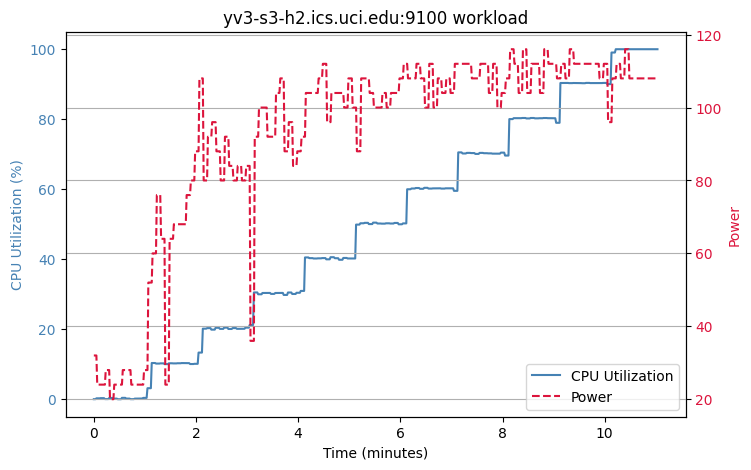

In [7]:
offline_mode = True

if offline_mode:
    print("Running in offline mode.")
else:
    print(f"Running in online mode. Make sure prometheus server is running at {g_live_mode_prometheus_url}")

exp1_config = {
    'start_time': 1694410677,
    'end_time': 1694411339,
    'filter_instance': ['yv3-s3-h2.ics.uci.edu:9100'],
    'offline_filename': 'exp1.data'
}

cpu_data, power_data = load_data(False, exp1_config)
timeline_plot(cpu_data, power_data)

# Experiment 2

To make things more interesting, now run different degrees of stress-tests on multiple hosts and then look a the power profiles

Running in online mode. Make sure prometheus server is running at http://localhost:9090


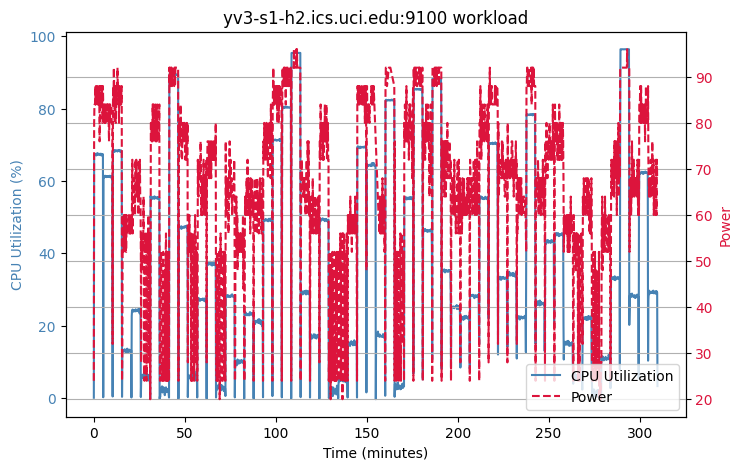

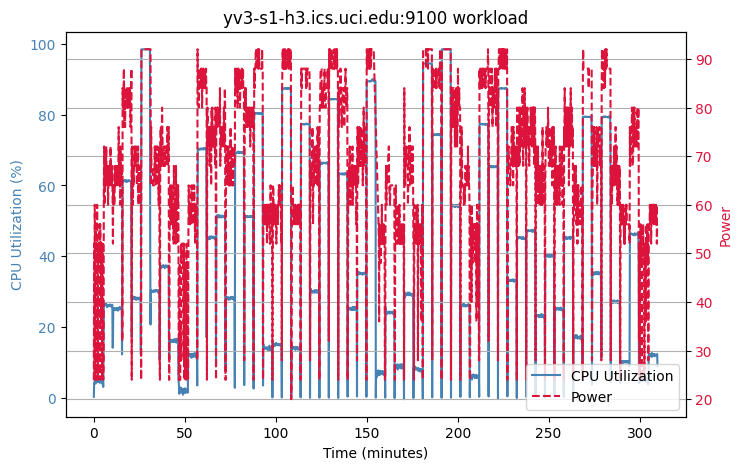

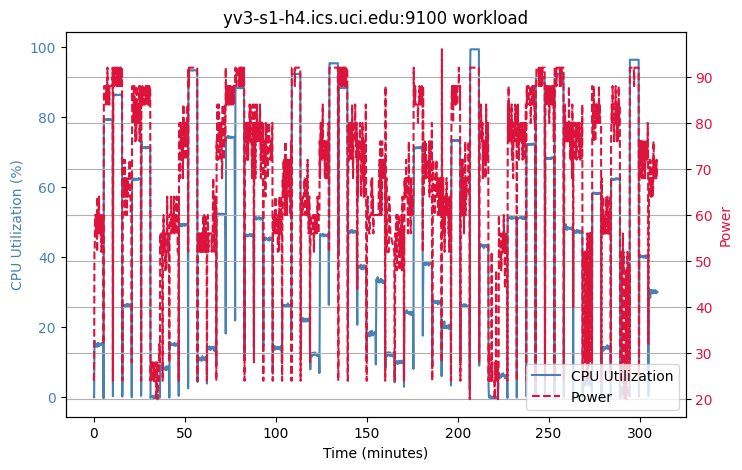

In [8]:
offline_mode = True

if offline_mode:
    print("Running in offline mode.")
else:
    print(f"Running in online mode. Make sure prometheus server is running at {g_live_mode_prometheus_url}")

exp2_config = {
    'start_time': 1694847234,
    'end_time': 1694865825,
    'filter_instance': ['yv3-s1-h2.ics.uci.edu:9100', 'yv3-s1-h3.ics.uci.edu:9100','yv3-s1-h4.ics.uci.edu:9100'],
    'offline_filename': 'exp2.data',
    'step': 10
}

cpu_data, power_data = load_data(False, exp2_config)
timeline_plot(cpu_data, power_data)

## Alignment of Metrics Data:

Prometheus metrics can come from various sources and may have different timestamps or irregular collection intervals.
By converting these metrics into histograms with aligned time window buckets, we can compare and analyze different metrics over the same time intervals.

In [9]:
# Define a function to create histograms with a specified time window size

def create_histograms(timestamps, values, window_size):
    # Convert timestamps to numpy array
    timestamps = np.array(timestamps)
    
    # Calculate the number of bins based on the window size and available data
    min_timestamp = timestamps.min()
    max_timestamp = timestamps.max()
    num_bins = int((max_timestamp - min_timestamp) / window_size) + 1
    
    # Create histograms
    hist, bin_edges = np.histogram(timestamps, bins=num_bins)
    hist_values = np.zeros(num_bins)
    
    for i in range(len(bin_edges) - 1):
        mask = (timestamps >= bin_edges[i]) & (timestamps < bin_edges[i + 1])
        if np.any(mask):
            hist_values[i] = np.mean(np.array(values)[mask])
    
    # Remove trailing NaN values
    last_non_nan_index = np.where(~np.isnan(hist_values))[0][-1]
    
    # Set trailing values to zero
    hist_values[last_non_nan_index + 1:] = 0
    bin_edges[last_non_nan_index + 2:] = 0
    
    return bin_edges, hist_values

# Specify the time window size (in seconds)
window_size = 5  # You can adjust this as needed

aligned_data={}

for host, data in cpu_data.items():
    # Create histograms for CPU and power data
    cpu_histogram = create_histograms(data['timestamps'], data['values'], window_size)
    power_histogram = create_histograms(power_data[host]['timestamps'], power_data[host]['values'], window_size)
    
    aligned_data[host] = {
        'timestamps': cpu_histogram[0][:-1].tolist(),
        'cpu': cpu_histogram[1].tolist(),
        'power': power_histogram[1].tolist() #Assuming same window size
    }


/tmp/ipykernel_496564/974219651.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(aligned_data))
/tmp/ipykernel_496564/974219651.py:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cpu_values, power_values, label=host, alpha=0.5, c=color)


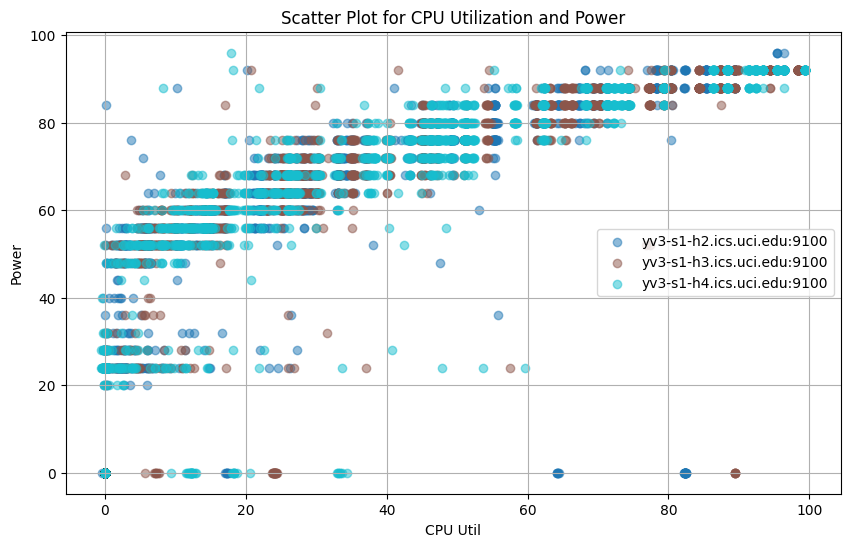

In [10]:
scatter_plot(aligned_data)

# CPU Util vs Power Model

The code models and visualizes the relationship between CPU utilization and power consumption for multiple hosts, using a piecewise model with a sigmoid transition to smoothly connect the two segments of the data.

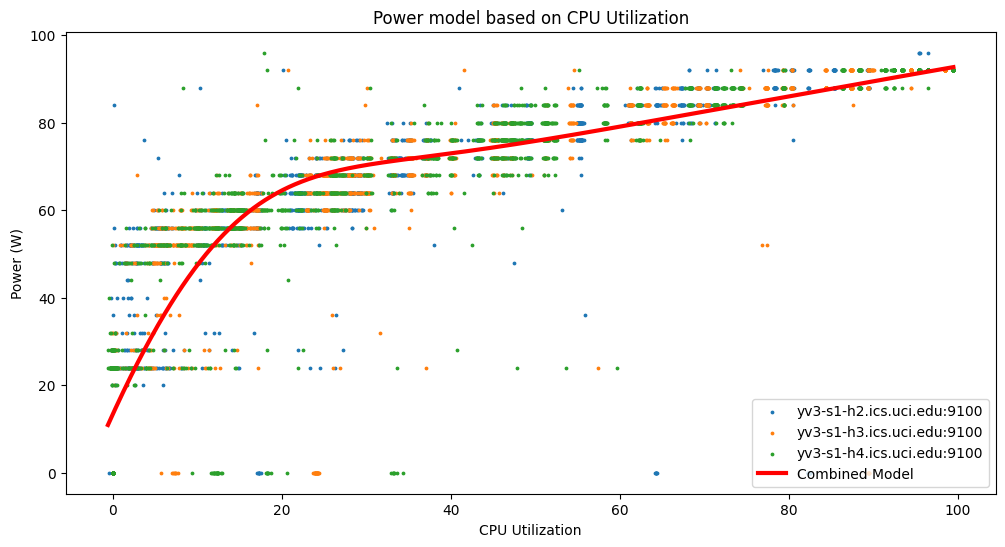

Parameters for the combined model [-0.056442758537491595, 4.07624181360041, 2.990918511224721, 0.33638643690578535, 59.30992187393608, 15, 0.1]


In [11]:
# Define polynomial functions for each segment (you can adjust the degrees)
def polynomial_func(x, a, b, c):
    return a * x**2 + b * x + c

def linear_func(x, m, c):
    return m * x + c

# Create the combined piecewise model with a sigmoid transition
def combined_model(x, a1, b1, c1, m2, c2, threshold, alpha):
    sigmoid = 1 / (1 + np.exp(-alpha * (x - threshold)))
    return a1 * x**2 + b1 * x + c1 + sigmoid * (linear_func(x, m2, c2) - (a1 * x**2 + b1 * x + c1))

def model_data(aligned_data):
    x = np.array([])  # Combined CPU Utilization data
    y = np.array([])  # Combined Power data
    
    plt.figure(figsize=(12, 6))    

    for host, data in aligned_data.items():
        cpu_values = data['cpu']
        power_values = data['power']
                            
        plt.scatter(cpu_values, power_values, label=f'{host}', s=3)
        # Concatenate the data from the current host to the combined data arrays
        x = np.concatenate((x, np.array(cpu_values)))
        y = np.concatenate((y, np.array(power_values)))
    

    x1 = x[x < 50]
    y1 = y[x < 50]
    params1, covariance1 = curve_fit(polynomial_func, x1, y1)

    # Fit linear_func to the data where x > 40 with better initial guesses
    x2 = x[x > 30]
    y2 = y[x > 30]
    params2, covariance2 = curve_fit(linear_func, x2, y2)


    x_range = np.linspace(min(x), max(x), 1000)

    # Plot the fitted combined model
    # plt.plot(x_range, polynomial_func1(x_range, *params1), label='Region 1', color='red')
    # plt.plot(x_range, linear_func(x_range, *params2), label='Region 2', color='green')

    # Use the combined_model function for the transition
    params_combined = [*params1, *params2, 15, 0.1]  # Adjust the transition parameters as needed
    plt.plot(x_range, combined_model(x_range, *params_combined), label='Combined Model', color='red', linewidth=3)


    plt.xlabel('CPU Utilization')
    plt.ylabel('Power (W)')
    plt.legend(loc='lower right')
    plt.title(f'Power model based on CPU Utilization')
    plt.show()  # Display each plot

    # Print the parameters for the combined model for each host
    print(f"Parameters for the combined model", params_combined)


model_data(aligned_data)
